<h1>GAN - Generative Adversarial Network</h1>

Ein GAN ist ein Netzwerk, das aus zwei verschiedenen Komponenten besteht. Das Ziel ist es Bilder zu generieren.

Ein GAN besteht aus:<br>
- Einem Generator, der ein Bild erzeugen soll. Durch Anpassung der Weights kann das Model in eine Richtung gelenkt werden, das am Ende ein Vektor ausgibt das als Bild angezeigt werden kann. Quasi das Gegenteil von einem CNN.
- Ein Discriminator, der das Generatornetz evaluiert.

Beide können aus einem ANN oder CNN erstellt werden. Je umfangreicher das Netz ist, desto mehr Features kann es besser Abdecken.

Ein einfaches Netz kann aus zwei ANNs erstellt werden. 

GANs können in verschiedene Use-Cases eingesetzt werden. Um ein erstes einfaches Beispiel zu erstellen, ist die Aufgabe synthetische Bilder von einem Produkt herzustellen was für eine Qualitätskontrolle genutzt werden kann.

<i>Abb1</i>: [Coming soon]

<img>

Als Komponente haben wir ein 20 x 20 Bild mit einem "L" darauf. Das L könnte ein L-förmiges Bauteil sein. Bei der Produktion werden viele dieser Komponenten hergestellt.Mit der Synthetisierung dieser Bilder können wir mehr Daten generieren, die für das Training eines CNN verwendet werden können, um Abweichungen besser abzudecken. 

Wir gehen davon aus das es viel mehr Bilder von guten Bauteilen gibt und sehr wenige von nicht guten Bauteilen. Mit den synthetischen Bildern kann die Lücke geschlossen werden.

In [1]:
# Imports.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

from sklearn.preprocessing import StandardScaler

<h2> Dataset </h2>

Um so ein Bild zu erstellen, kann ein Zeichenprogramm oder Numpy verwendet werden.

<i>Abb2</i>: Zeichnung L-Objekt.

<img src="./data/img/1_gan.PNG" width=400, height=400>

Alternativ kann auch mit Numpy eine einfache Form gezeichnet werden.

In [2]:
# Erstelle 1 Sample. 
def create_image(color:int=1) -> np.array:
    image = np.zeros((20, 20))  # 2D Matrix, 20x20 Pixel.
    # img [yloc, xloc]
    image[1:12, 7] = 1  # Zeichne Feld.
    image[1:12, 8] = 1  # Zeichne Feld.

    image[11, 9:15]  = 1  
    image[12, 7:15] = 1  

    return image

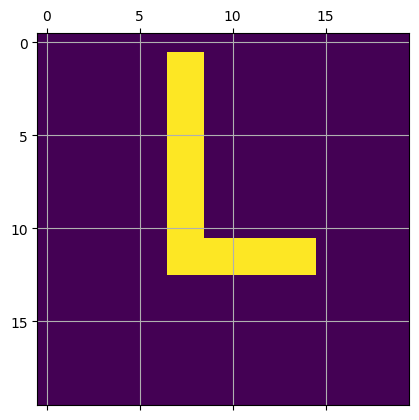

In [3]:
img = create_image()
plt.matshow(img)
plt.grid()

Schnell und einfach ist das Bild erstellt. 

<h3>Numpy Dataset</h3>

In [4]:
# Erstelle Dataset aus n-Samples 
def numpy_dataset(n:int):
    return np.array([create_image() for x in range(n)])
    
size = 950
dataset_numpy = numpy_dataset(size)
dataset_numpy.shape

(950, 20, 20)

In [5]:
dataset_numpy = dataset_numpy.reshape(size, 20, 20, 1).astype('float')

In [6]:
# Dann können die Daten normalisiert werden.
dataset_numpy_scaled = ( dataset_numpy - 0.5 ) / 0.5

Oder lade das Bild als numpy Array. 

In [9]:
# Lade Bild mit OpenCV.
# - Oder nutze Alternative wie PIL, ..., 
img = cv2.imread('./data/img/1_gan.PNG')
type(img)

numpy.ndarray

Danach kann das Bild in ein Dataframe geladen und ggf. Transformiert und angepasst werden.

<h3>Tensorflow Dataset</h3>

In [ ]:
# // Content coming 

<h2>GAN Model - ANN</h2>

Dann erstellen wir zwei separate ANN Netze die verschiedene Aufgaben übernehmen.

In [23]:
# Generator ANN #
gen_ann = tf.keras.Sequential([
    # Input 100 Units, Output 128 Units.
    tf.keras.layers.Dense(units=128, input_shape=(100,), activation='relu'),
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=400, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=400, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # Erstelle Vektor der dann als Bild 20x20 Pixel dargestellt wird.
    tf.keras.layers.Dense(units=20*20, activation='tanh'),
    tf.keras.layers.Reshape((20, 20, 1))
])

gen_ann.compile(
    optimizer = 'adam',
    loss      = 'binary_crossentropy'
)

# Discriminator ANN # 
dis_ann = tf.keras.Sequential([
    # Bild als Input. Netz soll Fake-Images erkennen. 
    tf.keras.layers.Flatten(input_shape=(20,20, 1)),
    tf.keras.layers.Dense(350, activation='relu'),
    tf.keras.layers.Dense(450, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    # Als Output: Fake oder nicht.
    tf.keras.layers.Dense(1, activation='sigmoid')
])

dis_ann.compile(
    optimizer = 'adam',
    loss      = 'binary_crossentropy',
    metrics   = 'accuracy'
)

Für einfache Formen sind die Netze ausreichend. Diese können später weiter optimiert werden.

Der nächste wichtige Schritt ist das Netz zu trainieren. Dazu fügen wir beide Netze zusammen und trainieren vorerst nur den Generator. 
- Mit einem Parameter können die Weights eines Models eingefroren werden. 

In [24]:
dis_ann.trainable = False

In [25]:
# Erstelle GAN
gan_input = tf.keras.layers.Input(shape=(100,))  # 100 Startpixel.
gen_image   = gen_ann(gan_input)

net_output = dis_ann(gen_image)
GAN        = tf.keras.Model(gan_input, net_output)

GAN.compile(optimizer='adam', loss='binary_crossentropy')

Anders als sonst in Tensorflow schreiben wir eine detailreiche Trainingsschleife. 
- Batching möglich.

Später werden wir uns weitere Details anschauen.

In [14]:
# Für das Batching: # 
# - Random-Index mit:
np.random.randint(0, 3, 3)  #  (low, high, size)

array([2, 1, 2])

In [15]:
# Generator Input # 
# - Üblich: Rauschen. Kann aber alles sein... 
#   => Aus dem Rauschen soll ein Bild entstehen. 
np.random.normal(0, 1, (2, 100))  # (loc, scale, size(x-Samples, shape))

array([[-0.02156837, -0.71190661,  1.36088468, -0.80407592,  0.13347914,
         0.50984788, -1.80216675, -0.50818803, -0.70648184,  0.1854621 ,
         0.31670522, -0.20302814, -0.77533357, -0.43206277, -0.23129412,
         1.28562439, -0.97365041, -0.67258307, -1.23906337,  0.68102533,
        -0.39392259,  0.31981078, -1.19549429,  1.81364233, -1.26484116,
         2.21910654,  0.82968061,  0.70035338, -0.76756405, -0.97922583,
        -0.93073212, -0.06020951,  1.22876206, -0.84197729, -0.66028986,
        -0.25177895, -0.05467518,  0.92977739, -1.07999372, -0.00692581,
         1.87825763, -0.80923744,  0.3823075 ,  0.53368414, -0.84705871,
        -0.56732853, -0.09008819,  1.72397455,  1.03610675,  1.85866803,
        -2.65799104,  0.45509704, -0.4620889 , -0.49524786, -0.59994832,
         0.50960967,  0.0995081 , -0.08704069,  0.73630232,  1.46378351,
         0.38085233,  0.45382795, -0.00835085,  1.2952008 , -2.32248931,
        -1.67446841, -0.30481555, -0.98180995, -0.0

In [20]:
np.ones(5)

array([1., 1., 1., 1., 1.])

In [28]:
# Trainingsschleife # 

def train(generator, discriminator, gan, train_img, epochs, batch_size):
    
    half_batch = int(batch_size / 2)
    
    for epoch in range(epochs):  # Für jede Epoche mach das:
        # Discriminator # 
        index = np.random.randint(0, train_img.shape[0], half_batch)  # Index für Samples. 
        real_images = train_img[index]  # Hole Samples.

        noise       = np.random.normal(0, 1, (half_batch, 100))  # Erstelle Rauschen als Input. Kann aber auch komplett 0 sein. Üblich: Rauschen.
        fake_images = generator.predict(noise)  # Erstelle Prediction. 

        # Berechne Loss. # Setze Labels.
        # - train_on_batch(x, y), beide müssen n-Samples haben. 
        loss_real = discriminator.train_on_batch(real_images, np.ones(  (half_batch, 1) ))  # Label 1 für n-Samples für echte Bilder. 
        loss_fake = discriminator.train_on_batch(fake_images, np.zeros( (half_batch, 1) ))  # Label 0 für n-Samples für UN-echte Bilder.
        d_loss = 0.5 * np.add(loss_real, loss_fake)  # Schnitt der Beiden Losses. 

        # Generator # 
        noise    = np.random.normal(0, 1, (batch_size, 100))
        y        = np.ones(batch_size)
        gan_loss = gan.train_on_batch(noise, y)

        # Manuelle Ausgabe.:
        print(f"Epoche: {epoch + 1}/{epochs} GAN loss: {gan_loss}")

In [29]:
train(gen_ann, dis_ann, GAN, dataset_numpy_scaled, epochs=500, batch_size=16)

1/1 [==============================] - 0s 227ms/step
Epoche: 1/500 GAN loss: 0.5209053158760071
1/1 [==============================] - 0s 14ms/step
Epoche: 2/500 GAN loss: 0.8491991758346558
1/1 [==============================] - 0s 14ms/step
Epoche: 3/500 GAN loss: 1.4610282182693481
1/1 [==============================] - 0s 14ms/step
Epoche: 4/500 GAN loss: 2.3235960006713867
1/1 [==============================] - 0s 14ms/step
Epoche: 5/500 GAN loss: 3.5769786834716797
1/1 [==============================] - 0s 14ms/step
Epoche: 6/500 GAN loss: 4.96592378616333
1/1 [==============================] - 0s 14ms/step
Epoche: 7/500 GAN loss: 6.143487930297852
1/1 [==============================] - 0s 14ms/step
Epoche: 8/500 GAN loss: 6.937300682067871
1/1 [==============================] - 0s 14ms/step
Epoche: 9/500 GAN loss: 7.73844051361084
1/1 [==============================] - 0s 14ms/step
Epoche: 10/500 GAN loss: 8.297172546386719
1/1 [==============================] - 0s 14ms/step
Epo